In [2]:
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
from celluloid import Camera
from IPython.display import HTML
import collections.abc
from matplotlib.gridspec import GridSpec
import ExoRIM as exo
import xara
import pickle
import matplotlib
%matplotlib inline

In [3]:
os.chdir("..")
basedir = os.getcwd()
basedir

'/home/alexandre/Desktop/Projects/ExoRIM'

In [48]:
# id = "20-07-06_20-58-35"
# id = "20-07-12_14-59-55"
# id = "20-07-12_14-06-21"
# id = "20-07-14_18-57-13"

# All these experiments somewhat failed because dataset wasn't properly normalized
# id = "20-07-15_16-40-40" # experiment with min max scalers -- wow! for CenteredCircle
# id = "20-07-15_16-59-40" # same as above but whith all reconstruction steps
# id = "20-07-15_17-20-41" # Now with slightly more difficult dataset
# id = "20-07-15_18-19-56" # now with the 12 steps
# id = "20-07-17_12-38-50" # first model with 6 steps 
# id = "20-07-17_16-02-33" # First try with multiple gradient channels (simple filter applied, no rescaling)
# id = "20-07-17_16-13-31" # second try without double filter

# Normalize dataset properly
# id = "20-07-17_16-31-33" # step size 6, 15 epochs
# id = "20-07-17_20-20-41" # step size 6, 85 epochs
# id = "20-07-17_20-34-01" # step size 12, 100 epochs
# id = "20-07-20_10-07-27" # 100 epochs with KLDivergence loss --> very bad
# id = "20-07-20_13-23-27" # KLDiverg with higher floor (1e-02) --> still bad
# id = "20-07-20_16-45-40" # test with 50 holes in mask
# id = "20-07-20_17-06-33"  # now without visibilities phase (amplitude and bispectra) results show convergence but no generalization-> need more data and BatchNorm for regularisation
# id = "20-07-22_15-13-35"  # Aperture Noise model with analytic gradients
# id = "20-07-22_18-19-16" # Ran on beluga with 1000 images
# id = "20-07-23_17-01-12"
# id = "20-07-29_21-21-42" 
# id = "20-07-29_22-25-50"  
# id = "20-07-29_23-04-30"  # model with only visibilities
id = "20-07-30_12-55-42"  # model with both closure phase and visibility amplitude
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id, "train")
test_data_dir = os.path.join(basedir, "data", id, "test")

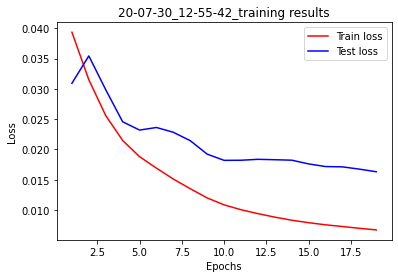

In [49]:
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "_training results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

In [5]:
test_loss.min()

0.02897207997739315

In [50]:
# update of nested dictionaries
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

images = {}
for file in glob.glob(os.path.join(results_dir, "output*")):
    name = os.path.split(file)[-1]
    if name[-3:] == "png":
        epoch = int(name[7:10])
        index = int(name[11:15])
        step = int(name[16:18])
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
            update(images, {index: {epoch : {step: im}}})
    elif name[-3:] == "txt":
        epoch = int(name[7:11])
        index = int(name[12:16])
        step = int(name[17:19])
        im = np.loadtxt(file)
        update(images, {index: {epoch : {step: im}}})
images.keys()

dict_keys([40])

In [51]:
log_grad = {}
for file in glob.glob(os.path.join(results_dir, "grad_[0-9]*")):
    name = os.path.split(file)[-1]
    epoch = int(name[5:9])
    index = int(name[10:14])
    step = int(name[15:17])
    g = np.loadtxt(file)
    update(log_grad, {index: {epoch : {step: g}}})
with open(os.path.join(results_dir, "grad_and_weights.pickle"), "rb") as f:
    grad_and_weights = pickle.load(f)

In [52]:
# ground_truth = {}
# for file in glob.glob(os.path.join(train_data_dir, "image[0-9]*")):
#     name = os.path.split(file)[-1]
#     index = int(name[5:8])
#     if name[-3:] == "png":
#         with Image.open(file) as image:
#             im = np.array(image.getdata()).reshape(image.size[0], image.size[1])
#             ground_truth[index] = im
#     elif name[-3:] == "txt":
#         ground_truth[index] = np.loadtxt(file)
ground_truth = {}
for file in glob.glob(os.path.join(train_data_dir, "image_[0-9]*")):
    name = os.path.split(file)[-1]
    epoch = int(name[6:10])
    index = int(name[11:-4])
    if name[-3:] == "png":
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape(image.size[0], image.size[1])
            ground_truth[index] = im
    elif name[-3:] == "txt":
        ground_truth[index] = np.loadtxt(file)
ground_truth.keys()

dict_keys([60, 80, 40, 20, 0])

In [53]:
%%capture

index = 40
# index = 50
step = 7
# step = 11
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
for key in sorted(list(selected_image.keys())):
    plt.imshow(selected_image[key][step], cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "output.mp4"), writer="ffmpeg")
anim1 = HTML(animation.to_html5_video())

In [54]:
%%capture
fig = plt.figure()
cam = Camera(fig)
for key in sorted(list(selected_image.keys())):
    plt.imshow((ground_truth[index] - selected_image[key][step]), cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "residual.mp4"), writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

In [55]:
%%capture

fig = plt.figure()
cam = Camera(fig)
selected_grad = log_grad[index]
for key in sorted(list(selected_grad.keys())):
    plt.imshow(selected_grad[key][step])
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "log_likelihood_grad.mp4"), writer="ffmpeg")
anim3 = HTML(animation.to_html5_video())

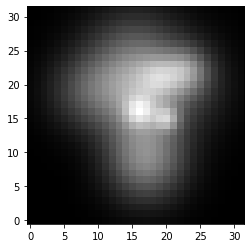

In [56]:
plt.figure()
plt.imshow(ground_truth[index], cmap="gray")
plt.savefig(os.path.join(results_dir, "ground_truth.png"))

In [57]:
# Output
anim1

In [58]:
# Residual
anim2

In [60]:
# likelihood grad
anim3

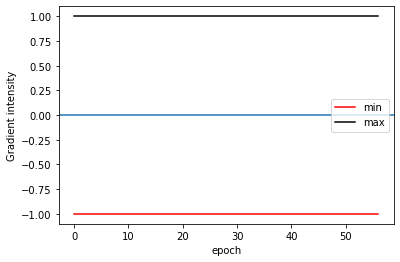

In [53]:
fig = plt.figure()
mi = []
ma = []
for key in sorted(list(selected_grad.keys())):
    mi.append(selected_grad[key][step].min())
    ma.append(selected_grad[key][step].max())
plt.axhline(0)
plt.plot(list(range(len(mi))), mi, "r-", label="min")
plt.plot(list(range(len(mi))), ma, "k-", label="max")
plt.xlabel("epoch")
plt.ylabel("Gradient intensity")
plt.legend()
plt.show()

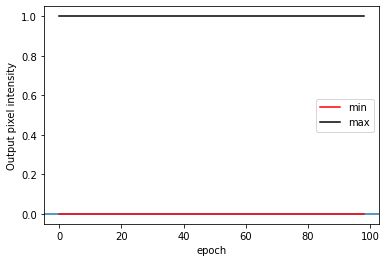

In [16]:
mi = []
ma = []
for key in sorted(list(selected_image.keys())):
    mi.append(selected_image[key][step].min())
    ma.append(selected_image[key][step].max())
plt.axhline(0)
plt.plot(list(range(len(mi))), mi, "r-", label="min")
plt.plot(list(range(len(mi))), ma, "k-", label="max")
plt.xlabel("epoch")
plt.ylabel("Output pixel intensity")
plt.legend()
plt.show()
# selected_image[1][2].max()

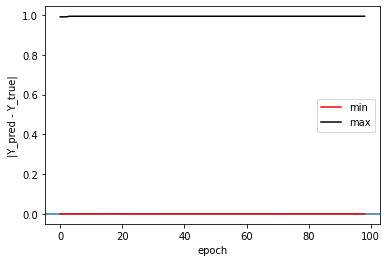

In [17]:

fig = plt.figure()
mi = []
ma = []
for key in sorted(list(selected_image.keys())):
    mi.append(np.abs(selected_image[key][step] - ground_truth[index]).min())
    ma.append(np.abs(selected_image[key][step] - ground_truth[index]).max())
plt.axhline(0)
plt.plot(list(range(len(mi))), mi, "r-", label="min")
plt.plot(list(range(len(mi))), ma, "k-", label="max")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("|Y_pred - Y_true|")
plt.show()

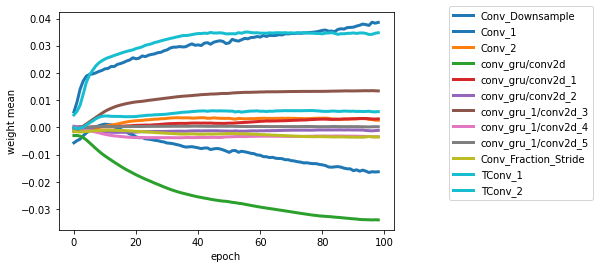

In [385]:
batch = 0
# map_layer_to_depth = {
#     "model/Conv_Downsample": 0,
#     "model/Conv_1": 1,
#     "model/conv_gru/conv2d": 2,
#     "model/conv_gru/conv2d_1": 3,
#     "model/conv_gru/conv2d_2": 4,
#     "model/conv_gru_1/conv2d_3": 5,
#     "model/conv_gru_1/conv2d_4": 6,
#     "model/conv_gru_1/conv2d_5": 7,
#     "model/Conv_Fraction_Stride": 8,
#     "model/TConv_1": 9
# }
map_layer_to_depth = {
    "model/Conv_Downsample": 0,
    "model/Conv_1": 1,
    "model/Conv_2": 2,
    "model/conv_gru/conv2d": 3,
    "model/conv_gru/conv2d_1": 4,
    "model/conv_gru/conv2d_2": 5,
    "model/conv_gru_1/conv2d_3": 6,
    "model/conv_gru_1/conv2d_4": 7,
    "model/conv_gru_1/conv2d_5": 8,
    "model/Conv_Fraction_Stride": 9,
    "model/TConv_1": 10,
    "model/TConv_2": 11
}
inv_map = {v: k for k, v in map_layer_to_depth.items()}

kernel_weight_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_max = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_min = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
for layer_name in grad_and_weights.keys():
    if "kernel" in layer_name:
        layer = layer_name[:-len("/kernel:0")]
        depth = map_layer_to_depth[layer]
        for epoch, d in grad_and_weights[layer_name].items():
            kernel_weight_mean[depth].append(d[batch]["weight_mean"])
            kernel_weight_var[depth].append(d[batch]["weight_var"])
            kernel_grad_mean[depth].append(d[batch]["grad_mean"])
            kernel_grad_var[depth].append(d[batch]["grad_var"])
            kernel_weight_max[depth].append(d[batch]["weight_max"])
            kernel_weight_min[depth].append(d[batch]["weight_min"])
cmap = matplotlib.cm.get_cmap("tab10")
norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_weight_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight mean")
plt.savefig(os.path.join(results_dir, "weight_mean.png"))
# name: epoch: batch: stats

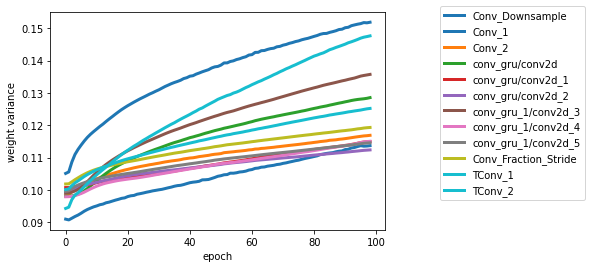

In [386]:
for depth, data in enumerate(kernel_weight_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight variance")
plt.savefig(os.path.join(results_dir, "weight_var.png"))

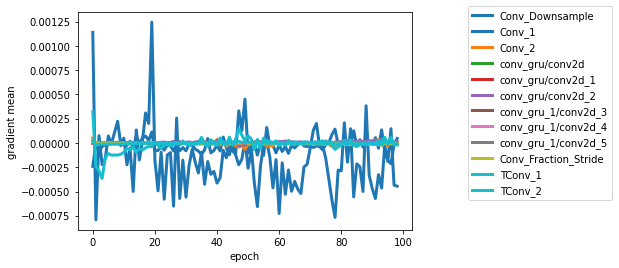

In [387]:
# cmap = matplotlib.cm.get_cmap("seismic")
# norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_grad_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient mean")
plt.savefig(os.path.join(results_dir, "backpropgrad_mean.png"))

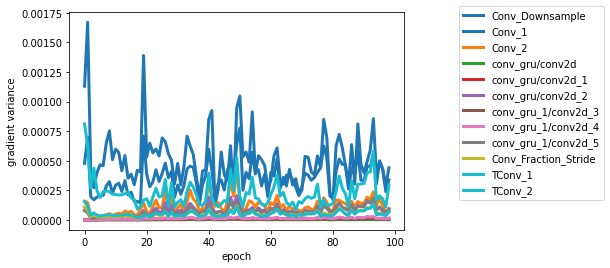

In [388]:
for depth, data in enumerate(kernel_grad_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient variance")
plt.savefig(os.path.join(results_dir, "backpropgrad_var.png"))

1225 distinct baselines found. Mask has 0 redundant baselines
There are 1176 independant closure phases
66.50198
tf.Tensor(66.64192, shape=(), dtype=float32)
0.13199411


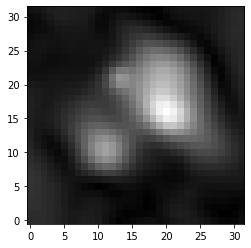

In [389]:
np.random.seed(42)
N = 50
wavel = 0.5e-6
pad = 0
pix = 32 + 0*pad
L = 6
plate_scale = 3.2
m = 1
SNR = 100
circle_mask = np.zeros((N, 2))
for i in range(N):
    circle_mask[i, 0] = (L + np.random.normal(0, m)) * np.cos(2 * np.pi * i / N)
    circle_mask[i, 1] = (L + np.random.normal(0, m)) * np.sin(2 * np.pi * i / N)
random_mask = np.random.normal(size=(N, 2))
image_coords = np.arange(pix) - pix / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
rho_squared = (xx - 5) ** 2 + (yy) ** 2
image += rho_squared == 0
rho_squared = (xx + 5) ** 2 + (yy) ** 2
image += np.exp(rho_squared / 5**2)
im = ground_truth[index] #np.pad(image, ((pad, pad), (pad, pad)), constant_values=(0, 0))
# im = np.pad(image, ((pad, pad), (pad, pad)), constant_values=(0, 0))
# plt.imshow(image, cmap="gray")
# baselines = exo.operators.Baselines(mask_coordinates=circle_mask)
# cpo = exo.operators.phase_closure_operator(baselines)
# dftm = exo.operators.NDFTM(baselines.UVC, wavel, pix, plate_scale)
# dftm_i = exo.operators.NDFTM(baselines.UVC, wavel, pix, plate_scale, inv=True)
# m2pix = exo.definitions.mas2rad(plate_scale) * pix / wavel
# phys = PhysicalModel(circle_mask, hyperparameters["pixels"], visibility_noise=1e-3, cp_noise=1e-5, m2pix=m2pix)
phys = exo.physical_model.PhysicalModelv2(pix, circle_mask, wavel, plate_scale, SNR)
pad2 = -pad if pad != 0 else None 
forward = phys.forward(np.reshape(im, [-1, pix, pix, 1]))
reconstructed_image = np.dot(phys.A_inverse, forward[0, :phys.p].numpy())
plt.imshow(np.reshape(np.abs(reconstructed_image), [pix, pix])[pad:pad2, pad:pad2], cmap="gray")
print(np.abs(reconstructed_image).max())
print(tf.math.reduce_logsumexp(np.abs(reconstructed_image)))
print(np.abs(reconstructed_image).min())
plt.savefig(os.path.join(results_dir, "dirty_image.png"))

In [ ]:
plt.imshow(im, cmap="gray")

In [ ]:
b = np.sqrt(baselines.UVC[:, 0]**2 + baselines.UVC[:, 1]**2)
bx = baselines.UVC[:, 0]
by = baselines.UVC[:, 1]
xara.core.rad2mas(wavel/2/b.max())
plt.plot(b, np.abs(forward[0, :phys.p])/np.pi, "k.")
plt.ylabel("Visibility amplitude")
plt.xlabel("Baseline")

In [ ]:
m2pix = exo.definitions.mas2rad(plate_scale) * 32 / wavel
1.22 * 12/m2pix/2/np.pi

In [394]:
basel = np.sqrt(phys.baselines.UVC[:, 0]**2 + phys.baselines.UVC[:, 1]**2)
basel.max()

14.908783613707246